<a href="https://colab.research.google.com/github/YakupTopaloglu/Speaker-Diarization/blob/main/BiLSTM_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import librosa.display
from sklearn.model_selection import train_test_split, GridSearchCV
import random

In [ ]:
# Dataset yolu
dataset_path = "/content/drive/MyDrive/HACIVAT&KARAGOZ/MODEL EĞİTİMİ/DATASET_20_VID"

# MFCC çıkaran temel fonksiyon
def load_wav_and_extract_features(file_path, num_mfcc=40, max_len=50):
    signal, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=num_mfcc)

    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

# SpecAugment uygulayan fonksiyon (frequency ve time masking)
def spec_augment(mfcc, frequency_masking_para=10, time_masking_para=10, num_masks=1):
    augmented_mfcc = mfcc.copy()

    for _ in range(num_masks):
        # Frequency masking
        freq_mask = random.randint(0, frequency_masking_para)
        freq_start = random.randint(0, augmented_mfcc.shape[0] - freq_mask)
        augmented_mfcc[freq_start:freq_start + freq_mask, :] = 0

        # Time masking
        time_mask = random.randint(0, time_masking_para)
        time_start = random.randint(0, augmented_mfcc.shape[1] - time_mask)
        augmented_mfcc[:, time_start:time_start + time_mask] = 0

    return augmented_mfcc

# Dataset oluşturma
def create_dataset(data_dir):
    X, y = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for label_name in class_names:
        folder_path = os.path.join(data_dir, label_name)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            if file.endswith('.wav'):
                file_path = os.path.join(folder_path, file)
                features = load_wav_and_extract_features(file_path)
                X.append(features)
                y.append(label_map[label_name])

    return np.array(X), np.array(y), class_names

# Veri setini yükle
X, y, class_names = create_dataset(dataset_path)

# Eğitim, Validation ve Test ayrımı
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

# Sadece eğitim verisine SpecAugment uygula
X_train_augmented = np.array([spec_augment(mfcc) for mfcc in X_train])
X_train_combined = np.concatenate((X_train, X_train_augmented), axis=0)
y_train_combined = np.concatenate((y_train, y_train), axis=0)
# Çıktılar
print("Veri Seti Boyutu:", X.shape)
print("Eğitim Kümesi:", X_train_combined.shape, y_train_combined.shape)
print("Validation Kümesi:", X_val.shape, y_val.shape)
print("Test Kümesi:", X_test.shape, y_test.shape)
print("Sınıf İsimleri:", class_names)

Veri Seti Boyutu: (4389, 40, 50)
Eğitim Kümesi: (5266, 40, 50) (5266,)
Validation Kümesi: (702, 40, 50) (702,)
Test Kümesi: (1054, 40, 50) (1054,)
Sınıf İsimleri: ['CALGI', 'DIGER', 'HACIVAT', 'KARAGOZ']


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(40, 50)),      # (n_mfcc, time)
    tf.keras.layers.Permute((2, 1)),            # -> (time_steps=50, n_mfcc=40)

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()
from contextlib import redirect_stdout
import io

stream = io.StringIO()
with redirect_stdout(stream):
    model.summary()
summary_string = stream.getvalue()
stream.close()

print(summary_string)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute_1 (Permute)             │ (None, 50, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 256)        │       173,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,924 (1.32 MB)

 Trainable params: 345,924 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute_1 (Permute)             │ (None, 50, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 256)        │       173,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,924 (1.32 MB)

 Trainable params: 345,924 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



history = model.fit(X_train_combined, y_train_combined,
                    epochs=10,
                    batch_size=16,
                    validation_data=(X_val, y_val))
                    # callbacks=[early_stopping])

Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - accuracy: 0.7354 - loss: 0.6209 - val_accuracy: 0.9302 - val_loss: 0.2151
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 79s 128ms/step - accuracy: 0.9294 - loss: 0.2271 - val_accuracy: 0.9160 - val_loss: 0.2264
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 89s 149ms/step - accuracy: 0.9429 - loss: 0.1817 - val_accuracy: 0.9473 - val_loss: 0.1760
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 75s 127ms/step - accuracy: 0.9492 - loss: 0.1579 - val_accuracy: 0.9430 - val_loss: 0.2072
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 82s 128ms/step - accuracy: 0.9568 - loss: 0.1301 - val_accuracy: 0.9345 - val_loss: 0.1976
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - accuracy: 0.9700 - loss: 0.0976 - val_accuracy: 0.9330 - val_loss: 0.2448
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.9606 - loss: 0.1210 - val_accuracy: 0.9430 - val_loss: 0.2103
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.9676 - loss: 0

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9415 - loss: 0.2480

Test Loss: 0.2362
Test Accuracy: 94.21%
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step


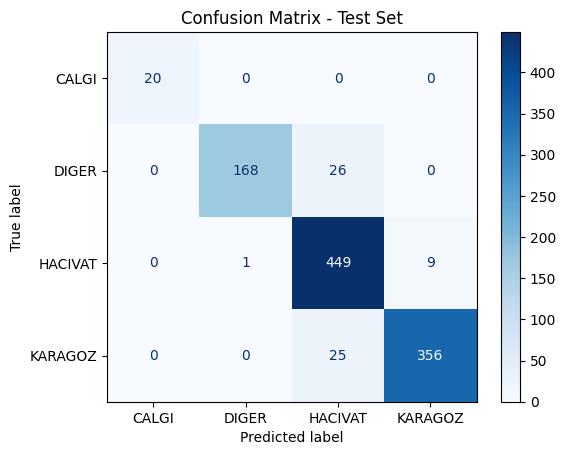


Classification Report:

              precision    recall  f1-score   support

       CALGI       1.00      1.00      1.00        20
       DIGER       0.99      0.87      0.93       194
     HACIVAT       0.90      0.98      0.94       459
     KARAGOZ       0.98      0.93      0.95       381

    accuracy                           0.94      1054
   macro avg       0.97      0.94      0.95      1054
weighted avg       0.95      0.94      0.94      1054



In [ ]:
# Test seti değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Test verisinde tahmin yap
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix oluştur
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix görselleatir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

# Classification report (Precision, Recall, F1)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

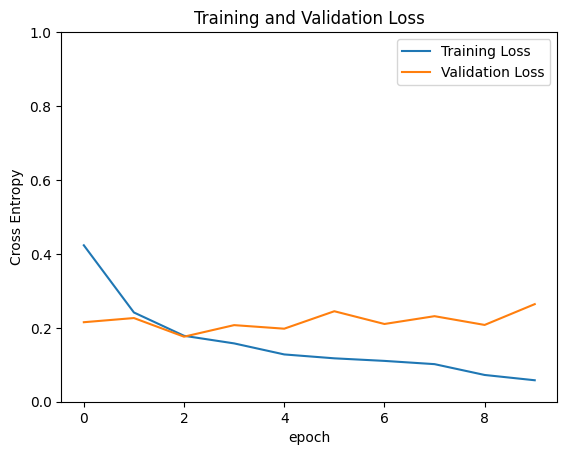

In [ ]:
loss =history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
# Modeli kaydet
model.save("karagoz_hacivat_cnn_model.h5")

# Örnek test
sample = X_test[0:1]
prediction = model.predict(sample)
predicted_label = np.argmax(prediction, axis=1)

print(f"Gerçek sınıf: {class_names[y_test[0]]}")
print(f"Tahmin edilen sınıf: {class_names[predicted_label[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Gerçek sınıf: KARAGOZ
Tahmin edilen sınıf: KARAGOZ
